# Import statements and initializations

In [1]:
import random
import os
import sys

import torch
import torchvision
from torchvision.transforms import v2

import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tqdm

import utils.self_utils as self_utils

TRITON_PTXAS_PATH="/usr/local/cuda-11.8/bin/ptxas"

dataset_path = './nabirds-data/nabirds'
image_path = os.path.join(dataset_path + '/images/')

ModuleNotFoundError: No module named 'nabirds'

### Set random seeds

In [2]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
_ = torch.manual_seed(SEED)

### Find cuda devices

In [3]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('CUDA enabled!')
else:
    device = 'cpu'
    print('CPU enabled. Fucking loser...')

CUDA enabled!


# Load Dataset

### Define transformations for the images

In [4]:
class CenterCrop(torch.nn.Module):
    def __init__(self, percent=0.8):
        super().__init__()
        self.frac = percent
    
    def forward(self, img):
        return v2.functional.center_crop(img, (int(self.frac*img.size[1]), int(self.frac*img.size[0])))

class rot90(torch.nn.Module):
    def __init__(self, percent=0.8):
        super().__init__()
        self.frac = percent
    
    def forward(self, img):
        return v2.functional.rotate(img, 90)

trans = v2.Compose([          #v2.RandomRotation(180),
                              #CenterCrop(),
                              #v2.RandomResizedCrop(224),
                              v2.Resize((192,192)),
                              rot90(),
                              #v2.RandomHorizontalFlip(),
                              v2.PILToTensor(),
                              v2.ConvertImageDtype(torch.float),
                              v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

invTrans = v2.Compose([ v2.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                v2.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

### Load dataset, stratify, and create dataloaders

In [5]:
import pickle
hierarchical_labels = {}
with open('hierarchical_class_labels.pkl', 'rb') as f:
    hierarchical_labels = pickle.load(f)

normalized_labels = []
with open('normalized_class_labels.pkl', 'rb') as f:
    normalized_labels = np.array(list(pickle.load(f).values()))

normalized_class_names = []
with open('normalized_class_mappings.pkl', 'rb') as f:
    normalized_class_names = pickle.load(f)

c1_freq = []
with open('c1_freq.pkl', 'rb') as f:
    c1_freq = torch.tensor(pickle.load(f))

c2_freq = []
with open('c2_freq.pkl', 'rb') as f:
    c2_freq = torch.tensor(pickle.load(f))

c3_freq = []
with open('c3_freq.pkl', 'rb') as f:
    c3_freq = torch.tensor(pickle.load(f))

c4_freq = []
with open('c4_freq.pkl', 'rb') as f:
    c4_freq = torch.tensor(pickle.load(f))

/tmp/ipykernel_3118111/3729381780.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c1_freq = torch.tensor(pickle.load(f))
/tmp/ipykernel_3118111/3729381780.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c2_freq = torch.tensor(pickle.load(f))
/tmp/ipykernel_3118111/3729381780.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c3_freq = torch.tensor(pickle.load(f))
/tmp/ipykernel_3118111/3729381780.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

In [6]:
print(normalized_labels)

[[  0   0   0   0]
 [  0   0   1   1]
 [  0   0   2   2]
 ...
 [  1  48 402 552]
 [  1  49 403 553]
 [  1  49 403 554]]


In [7]:
label = normalized_labels[420]
print(label)
print(normalized_class_names[0][label[0]])
print(normalized_class_names[1][label[1]])
print(normalized_class_names[2][label[2]])
print(normalized_class_names[3][label[3]])

[  1  44 318 420]
Perching Birds
Wood-Warblers
Blackburnian Warbler
Blackburnian Warbler


In [8]:
full_dataset = torchvision.datasets.ImageFolder(image_path, transform=trans)
split = 0.5
length = 48562
batch_size = 32
train_size = int((1-split) * length)
test_size = length - train_size

ds_train_idx, ds_test_idx = train_test_split(list(range(len(full_dataset))), test_size=split, stratify=full_dataset.targets, random_state=SEED)
ds_train = torch.utils.data.Subset(full_dataset, ds_train_idx)
ds_test = torch.utils.data.Subset(full_dataset, ds_test_idx)

train_dataloader = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True)

In [9]:
# c1_freq = [0] * 2
# c2_freq = [0] * 50
# c3_freq = [0] * 404
# c4_freq = [0] * 555

# for _, target in ds_train:
#     label = normalized_labels[target]
#     c1_freq[label[0]] += 1
#     c2_freq[label[1]] += 1
#     c3_freq[label[2]] += 1
#     c4_freq[label[3]] += 1

# c1_freq = torch.sum(c1_freq) / (c1_freq * c1_freq.shape[0])
# c2_freq = torch.sum(c2_freq) / (c2_freq * c2_freq.shape[0])
# c3_freq = torch.sum(c3_freq) / (c3_freq * c3_freq.shape[0])
# c4_freq = torch.sum(c4_freq) / (c4_freq * c4_freq.shape[0])
print(c1_freq)
print(c2_freq)
print(c3_freq)
print(c4_freq)

tensor([0.9793, 1.0216])
tensor([ 0.1611,  1.0792,  1.7788,  1.2080, 18.6777,  1.6631,  0.5188,  0.3608,
         1.3995,  1.6688,  0.3290,  3.9805,  0.6652,  2.7436, 11.2935,  5.9222,
         1.4158, 23.1248,  0.5700, 16.1873,  0.7708,  0.6625,  6.4749,  1.0557,
         0.6518, 16.7455,  1.0937,  1.1189, 26.9789, 13.1249,  2.5425,  8.8295,
         1.5615,  4.0468,  8.0937,  6.3897,  8.2308,  0.9541,  2.0067,  3.5190,
         9.1626,  4.5813,  4.1154,  4.1864,  0.2150,  0.2745,  0.4509,  0.4336,
         0.5043,  6.0703])
tensor([2.3116, 1.8782, 0.7805, 1.0017, 2.6131, 1.0017, 1.0362, 1.2521, 1.0017,
        1.4659, 0.5319, 0.6605, 0.7705, 1.4659, 0.7608, 1.3066, 1.0544, 0.8122,
        0.8014, 0.7155, 0.6261, 0.7329, 2.2260, 0.7071, 0.9540, 0.5565, 0.3954,
        0.5514, 0.5051, 0.5670, 0.6394, 0.6394, 0.6071, 0.6830, 0.6326, 1.1340,
        0.6753, 0.6010, 0.4519, 1.5025, 0.6071, 0.5008, 2.7319, 0.9106, 1.0017,
        1.3977, 0.6326, 0.6196, 0.7420, 1.0187, 0.8233, 0.6605, 0.61

In [10]:
# with open('c1_freq.pkl', 'wb') as f:
#     hierarchical_labels = pickle.dump(c1_freq, f)

# with open('c2_freq.pkl', 'wb') as f:
#     hierarchical_labels = pickle.dump(c2_freq, f)

# with open('c3_freq.pkl', 'wb') as f:
#     hierarchical_labels = pickle.dump(c3_freq, f)

# with open('c4_freq.pkl', 'wb') as f:
#     hierarchical_labels = pickle.dump(c4_freq, f)

In [11]:
true_class_names = self_utils.load_class_names(dataset_path)
class_names = tuple([true_class_names['class'][int(i)] for i in full_dataset.classes])
num_classes = len(class_names)

### Utility functions to view images

In [12]:
def getter(label):
    #idx = int(torch.argmax(label))
    return class_names[label] 

def show_img(img, ax=None, title=None):
    """Shows a single image."""
    img = invTrans(img)
    img = img.swapaxes(0,2)
    if ax is None:
        ax = plt.gca()
    ax.imshow(img[...])
    ax.set_xticks([])
    ax.set_yticks([])
    if title:
        ax.set_title(title)

def show_img_grid(imgs, titles):
    """Shows a grid of images."""
    n = int(np.ceil(len(imgs)**.5))
    _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
    for i, (img, title) in enumerate(zip(imgs, titles)):
        show_img(img, axs[i // n][i % n], title)

In [13]:
imgs, labels = next(iter(test_dataloader))
print(imgs.shape) # Need to swapaxes for display
print(labels.shape) # Need onehot encoding during training!

torch.Size([32, 3, 192, 192])
torch.Size([32])


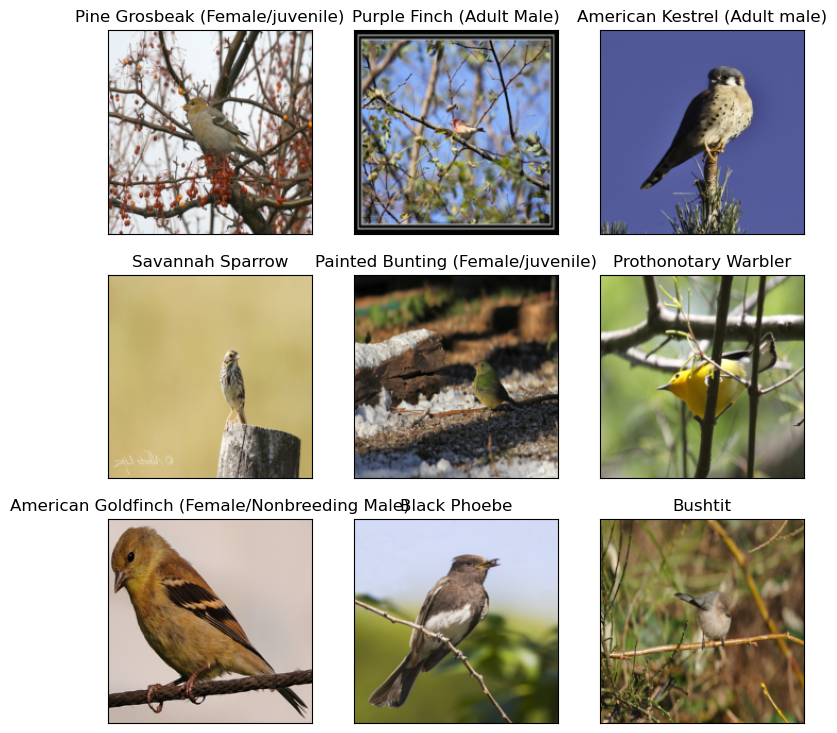

In [14]:
titles = map(getter, labels[:9])
show_img_grid(imgs[:9], titles)

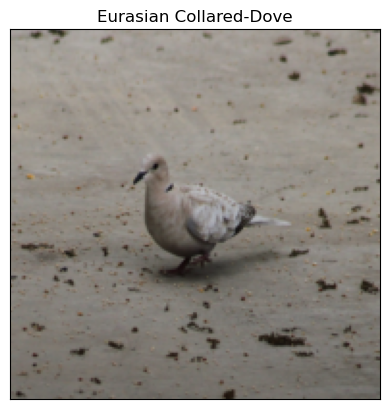

In [15]:
show_img(imgs[-1], title=getter(labels[-1]))

# Prepare to train model

### Muon Optimizer

In [16]:
def zeropower_via_newtonschulz5(G, steps=3, eps=1e-7):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' sim Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750,  2.0315)
    X = G.bfloat16()
    X /= (X.norm() + eps) # ensure top singular value <= 1
    if G.size(0) > G.size(1):
        X = X.T
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
    if G.size(0) > G.size(1):
        X = X.T
    return X

class Muon(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0, nesterov=False):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if momentum < 0.0:
            raise ValueError(f"Invalid momentum value: {momentum}")
        if nesterov and momentum <= 0:
            raise ValueError("Nesterov momentum requires a momentum")
        defaults = dict(lr=lr, momentum=momentum, nesterov=nesterov)
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            for p in group['params']:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]

                if 'momentum_buffer' not in state.keys():
                    state['momentum_buffer'] = torch.zeros_like(g)
                buf = state['momentum_buffer']
                buf.mul_(momentum).add_(g)
                g = g.add(buf, alpha=momentum) if group['nesterov'] else buf

                p.data.mul_(len(p.data)**0.5 / p.data.norm()) # normalize the weight
                update = zeropower_via_newtonschulz5(g.reshape(len(g), -1)).view(g.shape) # whiten the update
                p.data.add_(update, alpha=-lr) # take a step

### Model Definition

In [17]:
from CascadeHead import CascadeHead
def create_cascade_model(pretrain=True, type='21k', cumulative=True):
    if pretrain and type == 'torch':
        swin = torchvision.models.swin_v2_b(weights='IMAGENET1K_V1')
    elif pretrain and type == '21k':
        swin = torch.load('./Models/pretrained_swinv2.pt', weights_only=False)
    elif pretrain and type == '21k_big':
        swin = torch.load('./Models/pretrained_swinv2_384.pt', weights_only=False)
        #model = swin_transformer_v2.SwinTransformerV2()
        #model.load_state_dict(torch.load('./Models/swinv2_large_patch4_window12_192_22k_256_256.pth', weights_only=False))
    else:
        swin = torchvision.models.swin_v2_b()
    
    in_features = swin.head.in_features
    out_features = num_classes

    if type == 'torch':
        new_head = CascadeHead(in_features, layers=4, layer_dims=[2,50,404,555], activation=torch.nn.ReLU, cumulative=cumulative, device=device)
        swin.head = new_head
    elif type == '21k':
        swin.head = torch.nn.Sequential(
            swin.head.global_pool,
            swin.head.drop,
            CascadeHead(backbone_out=1536, layers=4, layer_dims=[2,50,404,555], activation=torch.nn.ReLU),
        )

    if pretrain:
        for param in swin.parameters():
            param.requires_grad = False

        swin.head.requires_grad_ = True

        for name, param in swin.named_parameters():
            if 'head' in name: param.requires_grad = True
            #if 'features.7' in name: param.requires_grad = True
            if 'layers.3' in name: param.requires_grad = True
            if name == 'norm.bias': param.requires_grad = True
            if name == 'norm.weight': param.requires_grad = True
                
    for name, param in swin.named_parameters():
        print(name, param.requires_grad)
    
    return swin

### Model Training
Need to enable training with multiple loss functions, get output from each layer.

In [19]:
def train(model, optimizer, criterion, steps, train, test, test_steps, epochs=1, device='cuda:0', normalized_labels=None):
    losses = torch.zeros(epochs).to(device)
    model.train()


    loss_rec = torch.tensor([2, 50, 404, 555])
    loss_rec = -1 * torch.log(1. / loss_rec)
    loss_rec = 1. / loss_rec
    print(loss_rec)
    
    for epoch in range(epochs):
        ls = 0
        for i, (X, y) in zip(tqdm.trange(steps), train):
            X = torch.Tensor(X).to(device)
            label = normalized_labels[y]
            y1 = torch.Tensor(label[:,0]).to(torch.long).to(device) 
            y2 = torch.Tensor(label[:,1]).to(torch.long).to(device) 
            y3 = torch.Tensor(label[:,2]).to(torch.long).to(device) 
            y4 = torch.Tensor(label[:,3]).to(torch.long).to(device) 
        
            pred = model.forward(X)
            
            y1 = torch.nn.functional.one_hot(y1, num_classes=2).to(torch.float32)
            y2 = torch.nn.functional.one_hot(y2, num_classes=50).to(torch.float32)
            y3 = torch.nn.functional.one_hot(y3, num_classes=404).to(torch.float32)
            y4 = torch.nn.functional.one_hot(y4, num_classes=555).to(torch.float32)
            #pred = torch.nn.functional.softmax(pred, dim=-1)
            
            loss1 = criterion[0](pred[0], y1)
            
            loss2 = criterion[1](pred[1], y2)

            loss3 = criterion[2](pred[2], y3)
            
            loss4 = criterion[3](pred[3], y4)

            #loss = loss1
            loss = loss_rec[0]*loss1 + loss_rec[1]*loss2 + loss_rec[2]*loss3 + loss_rec[3]*loss4
            #loss = loss1 + loss2 + loss3 + loss4
            #loss = loss4
            loss.backward()
            
            if (i % 1) == 0:
                for opt in optimizer:
                    opt.step()
                    opt.zero_grad(set_to_none=True)
            ls += loss.item()
        losses[epoch] = ls / steps
        print('Epoch ' + str(epoch + 1) + '/' + str(epochs) + ' Loss: ' + str(losses[epoch].item()))
    
        if (epoch > 0 and ((epoch+1) % 5) == 0) or epoch == epochs - 1:
            cm = evaluate(model, criterion, test, test_steps)
            model.train()
            print('Passerine v. Nonpasserine')
            print(cm[0])
            print(torch.sum(torch.diag(cm[0])) / torch.sum(cm[0]))
            print('Type')
            print(cm[1])
            print(torch.sum(torch.diag(cm[1])) / torch.sum(cm[1]))
            print('Species')
            print(cm[2])
            print(torch.sum(torch.diag(cm[2])) / torch.sum(cm[2]))
            print('sub-Species')
            print(cm[3])
            print(torch.sum(torch.diag(cm[3])) / torch.sum(cm[3]))
    
    return losses

In [20]:
def evaluate(model, criterion, test, steps, device='cuda:0'):
    model.eval()

    cm = [
            torch.zeros(2, 2).to(device),
            torch.zeros(50, 50).to(device),
            torch.zeros(404, 404).to(device),
            torch.zeros(555, 555).to(device)
    ]
    
    good = total = 0
    with torch.no_grad():
        for _, (X, y) in zip(tqdm.trange(steps), test):
            X = torch.Tensor(X).to(device)
            label = normalized_labels[y]
            y1 = torch.Tensor(label[:,0]).to(device) 
            y2 = torch.Tensor(label[:,1]).to(device) 
            y3 = torch.Tensor(label[:,2]).to(device) 
            y4 = torch.Tensor(label[:,3]).to(device) 
        
            pred = model(X)
            pred1 = torch.argmax(pred[0], dim=-1)
            pred2 = torch.argmax(pred[1], dim=-1)
            pred3 = torch.argmax(pred[2], dim=-1)
            pred4 = torch.argmax(pred[3], dim=-1)

            cm[0][pred1.to(torch.long), y1.to(torch.long)] += 1
            cm[1][pred2.to(torch.long), y2.to(torch.long)] += 1
            cm[2][pred3.to(torch.long), y3.to(torch.long)] += 1
            cm[3][pred4.to(torch.long), y4.to(torch.long)] += 1
            
    return cm

In [39]:
n_epochs = 50
steps = int(train_size // batch_size)
muon_lr = 0.05
#adam_lr = 0.000030625 / 2
adam_lr = 0.006
model = create_cascade_model(cumulative=False).to(device)
optimizer = [torch.optim.Adam(model.parameters(),lr=adam_lr)] #, betas=(0.90, 0.95), weight_decay = 0.001)]
#muon_params = [p for p in model.parameters() if p.ndim >= 2 and p.requires_grad == True]
#adam_params = [p for p in model.parameters() if p.ndim < 2]

from torch.optim import lr_scheduler
scheduler = lr_scheduler.LinearLR(optimizer[0], start_factor=0.1, end_factor=1, total_iters=5)

#print(len(list(model.parameters())))
#print(len(muon_params) + len(adam_params))

#optimizer = [Muon(muon_params, lr=muon_lr, momentum=0.95), torch.optim.Adam(adam_params, lr=adam_lr, betas=(0.90, 0.95), weight_decay = 0.01)]
#print(optimizer)
#criterion = torch.nn.CrossEntropyLoss()
criterion = [torch.nn.CrossEntropyLoss(weight=c1_freq.to(device)),
             torch.nn.CrossEntropyLoss(weight=c2_freq.to(device)),
             torch.nn.CrossEntropyLoss(weight=c3_freq.to(device)),
             torch.nn.CrossEntropyLoss(weight=c4_freq.to(device))]

print(model)

patch_embed.proj.weight False
patch_embed.proj.bias False
patch_embed.norm.weight False
patch_embed.norm.bias False
layers.0.blocks.0.attn.logit_scale False
layers.0.blocks.0.attn.q_bias False
layers.0.blocks.0.attn.v_bias False
layers.0.blocks.0.attn.cpb_mlp.0.weight False
layers.0.blocks.0.attn.cpb_mlp.0.bias False
layers.0.blocks.0.attn.cpb_mlp.2.weight False
layers.0.blocks.0.attn.qkv.weight False
layers.0.blocks.0.attn.proj.weight False
layers.0.blocks.0.attn.proj.bias False
layers.0.blocks.0.norm1.weight False
layers.0.blocks.0.norm1.bias False
layers.0.blocks.0.mlp.fc1.weight False
layers.0.blocks.0.mlp.fc1.bias False
layers.0.blocks.0.mlp.fc2.weight False
layers.0.blocks.0.mlp.fc2.bias False
layers.0.blocks.0.norm2.weight False
layers.0.blocks.0.norm2.bias False
layers.0.blocks.1.attn.logit_scale False
layers.0.blocks.1.attn.q_bias False
layers.0.blocks.1.attn.v_bias False
layers.0.blocks.1.attn.cpb_mlp.0.weight False
layers.0.blocks.1.attn.cpb_mlp.0.bias False
layers.0.blocks.

In [40]:
test_steps = int(test_size // batch_size)
#accuracy = evaluate(model, criterion, test_dataloader1
#print(accuracy)

In [38]:
losses = train(model, optimizer, criterion, steps, train_dataloader, test_dataloader, test_steps, n_epochs, device=device, normalized_labels=normalized_labels)
plt.plot(np.arange(n_epochs), losses.cpu())

tensor([1.4427, 0.2556, 0.1666, 0.1583])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [04:47<00:00,  2.64it/s]


Epoch 1/50 Loss: 1.3920117616653442


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [04:48<00:00,  2.63it/s]


Epoch 2/50 Loss: 0.4283539652824402


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [04:49<00:00,  2.62it/s]


Epoch 3/50 Loss: 0.2508319914340973


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [04:50<00:00,  2.61it/s]


Epoch 4/50 Loss: 0.16231626272201538


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [04:59<00:00,  2.53it/s]


Epoch 5/50 Loss: 0.12093774974346161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [02:40<00:00,  4.72it/s]


Passerine v. Nonpasserine
tensor([[758., 137.],
        [116., 758.]], device='cuda:0')
tensor(0.8570, device='cuda:0')
Type
tensor([[730.,   3.,   1.,  ...,   0.,   1.,   0.],
        [126., 341.,   5.,  ...,   1.,   0.,   0.],
        [  0.,   2., 187.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 494.,  19.,   1.],
        [  0.,   1.,   0.,  ...,  40., 518.,   0.],
        [  0.,   0.,   0.,  ...,   2.,   0.,  58.]], device='cuda:0')
tensor(0.7741, device='cuda:0')
Species
tensor([[23.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 27.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 67.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 34.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0., 25.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 45.]], device='cuda:0')
tensor(0.8052, device='cuda:0')
sub-Species
tensor([[23.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 27.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 40.,  ...,  0.,  0.,  0.],
   

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [05:02<00:00,  2.51it/s]


Epoch 6/50 Loss: 0.09083905816078186


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [04:55<00:00,  2.57it/s]


Epoch 7/50 Loss: 0.07473289966583252


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [04:44<00:00,  2.67it/s]


Epoch 8/50 Loss: 0.05898655578494072


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [04:44<00:00,  2.66it/s]


Epoch 9/50 Loss: 0.050704557448625565


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [04:45<00:00,  2.66it/s]


Epoch 10/50 Loss: 0.04575645923614502


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [02:33<00:00,  4.95it/s]


Passerine v. Nonpasserine
tensor([[758., 154.],
        [ 97., 758.]], device='cuda:0')
tensor(0.8580, device='cuda:0')
Type
tensor([[736.,  10.,   0.,  ...,   1.,   1.,   0.],
        [ 22., 321.,   8.,  ...,   1.,   0.,   0.],
        [  1.,   2., 215.,  ...,   0.,   0.,   0.],
        ...,
        [  1.,   0.,   0.,  ..., 530.,  41.,   2.],
        [  0.,   1.,   0.,  ...,  19., 475.,   0.],
        [  0.,   0.,   0.,  ...,   3.,   0.,  61.]], device='cuda:0')
tensor(0.8024, device='cuda:0')
Species
tensor([[23.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 28.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 55.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 30.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0., 26.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 53.]], device='cuda:0')
tensor(0.8214, device='cuda:0')
sub-Species
tensor([[23.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 28.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 38.,  ...,  0.,  0.,  0.],
   

 21%|██████████████████████████████████████████████████▌                                                                                                                                                                                                 | 157/758 [00:59<03:47,  2.64it/s]


KeyboardInterrupt: 

In [ ]:
cm = evaluate(model, criterion, test_dataloader, test_steps)
print('-'*50)
print('Passerine v. Nonpasserine')
print(cm[0])
print('C1 Accuracy = ' + str(torch.sum(torch.diag(cm[0])) / torch.sum(cm[0]).item()))

print('-'*50)
print('Type')
print(cm[1])
print('C2 Accuracy = ' + str(torch.sum(torch.diag(cm[1])) / torch.sum(cm[1]).item()))

print('-'*50)
print('Species')
print(cm[2])
print('C3 Accuracy = ' + str(torch.sum(torch.diag(cm[2])) / torch.sum(cm[2]).item()))

print('-'*50)
print('sub-Species')
print(cm[3])
print('C4 Accuracy = ' + str(torch.sum(torch.diag(cm[3])) / torch.sum(cm[3]).item()))
print('-'*50)

In [41]:
def getter(label):
    #idx = int(torch.argmax(label))
    return class_names[label] 

def show_img(img, ax=None, title=None):
    """Shows a single image."""
    img = invTrans(img)
    img = img.swapaxes(0,2)
    if ax is None:
        ax = plt.gca()
    ax.imshow(img[...])
    ax.set_xticks([])
    ax.set_yticks([])
    if title:
        ax.set_title(title)

def show_img_grid(imgs, titles):
    """Shows a grid of images."""
    n = int(np.ceil(len(imgs)**.5))
    _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
    for i, (img, title) in enumerate(zip(imgs, titles)):
        show_img(img, axs[i // n][i % n], title)

In [42]:
imgs, labels = next(iter(test_dataloader))
print(imgs.shape) # Need to swapaxes for display
print(labels.shape) # Need onehot encoding during training!

torch.Size([32, 3, 192, 192])
torch.Size([32])


In [43]:
hierarchy_labels = normalized_labels[labels]
print(hierarchy_labels)

[[  0   0  20  30]
 [  0   0  37  65]
 [  1  44 324 429]
 [  0   7  85 133]
 [  0   1  43  76]
 [  0   0   8   9]
 [  0   2  48  84]
 [  0   7  88 139]
 [  1  43 299 396]
 [  1  26 240 332]
 [  0   6  66 109]
 [  1  44 324 429]
 [  1  21 206 297]
 [  1  30 262 355]
 [  1  21 200 291]
 [  1  47 376 510]
 [  1  45 336 444]
 [  0   7  90 143]
 [  1  24 231 323]
 [  1  44 328 436]
 [  1  45 359 476]
 [  0   0   2   2]
 [  0   1  39  70]
 [  1  48 398 545]
 [  1  44 323 428]
 [  0   7  93 151]
 [  1  44 325 432]
 [  0  10 119 185]
 [  1  24 226 318]
 [  0   6  71 116]
 [  0  18 175 255]
 [  1  45 359 475]]


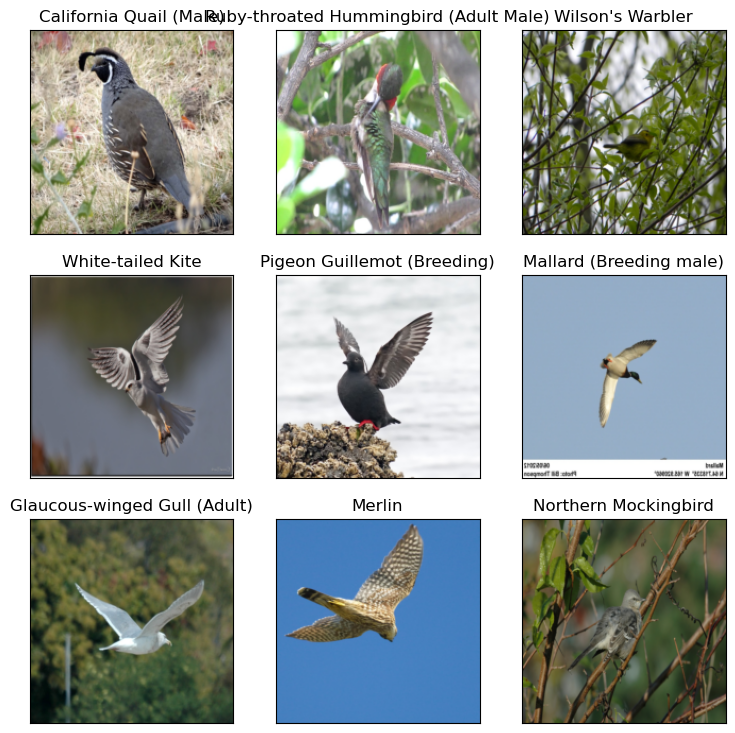

In [44]:
titles = map(getter, labels[:9])
show_img_grid(imgs[:9], titles)

In [45]:
def infer_show_img(model, imgs, ax=None, title=None):
    """Shows a single image."""
    model.eval()
    with torch.no_grad():
        pred = model.forward(imgs.to(device)) 

    print(pred.shape)
    pred = torch.argmax(torch.nn.functional.softmax(torch.tensor(pred[-1]), dim=-1), dim=-1)
    print(pred)
    print(title)
    
    true_title = "True Label: " + title + "\nPredicted Label: " + getter(pred[0].item())
    
    img = invTrans(imgs[0])
    img = img.swapaxes(0,2)
    if ax is None:
        ax = plt.gca()
    ax.imshow(img[...])
    ax.set_xticks([])
    ax.set_yticks([])
    if title:
        ax.set_title(true_title)

def infer_show_img_grid(model, imgs, titles):
    """Shows a grid of images."""

    model.eval()
    with torch.no_grad():
        pred = model.forward(imgs.to(device)) 

    pred = torch.argmax(torch.nn.functional.softmax(torch.tensor(pred[-1]), dim=-1), dim=-1)

    for i in range(len(list(titles))):
        titles[i] = "T: " + titles[i] + "\nP: " + getter(pred[i].item())

    print(titles)

    n = int(np.ceil(len(imgs)**.5))
    _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
    print(imgs[0].shape)
    for i, (img, title) in enumerate(zip(imgs, titles)):
        show_img(img, axs[i // n][i % n], title)

/tmp/ipykernel_387903/1259785283.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.argmax(torch.nn.functional.softmax(torch.tensor(pred[-1]), dim=-1), dim=-1)


['T: Lazuli Bunting (Female/juvenile)\nP: Lazuli Bunting (Female/juvenile)', 'T: Red-winged Blackbird (Male)\nP: Red-winged Blackbird (Male)', 'T: Prothonotary Warbler\nP: Prothonotary Warbler', 'T: American Kestrel (Female, immature)\nP: American Kestrel (Female, immature)', 'T: Brown Creeper\nP: Brown Creeper', 'T: Northern Cardinal (Female/Juvenile)\nP: Northern Cardinal (Female/Juvenile)', 'T: Yellow-breasted Chat\nP: Yellow-breasted Chat', 'T: Ring-necked Pheasant (Female/juvenile)\nP: Ring-necked Pheasant (Female/juvenile)', 'T: American Goldfinch (Female/Nonbreeding Male)\nP: Lesser Goldfinch (Female/juvenile)', 'T: Brown-headed Cowbird (Male)\nP: Brown-headed Cowbird (Male)', 'T: Merlin\nP: Merlin', 'T: Baltimore Oriole (Female/Immature male)\nP: Baltimore Oriole (Female/Immature male)', 'T: Black Skimmer\nP: Black Skimmer', 'T: Solitary Sandpiper\nP: Solitary Sandpiper', 'T: Marbled Godwit\nP: Marbled Godwit', 'T: Common Gallinule (Adult)\nP: Common Gallinule (Adult)', 'T: Lar

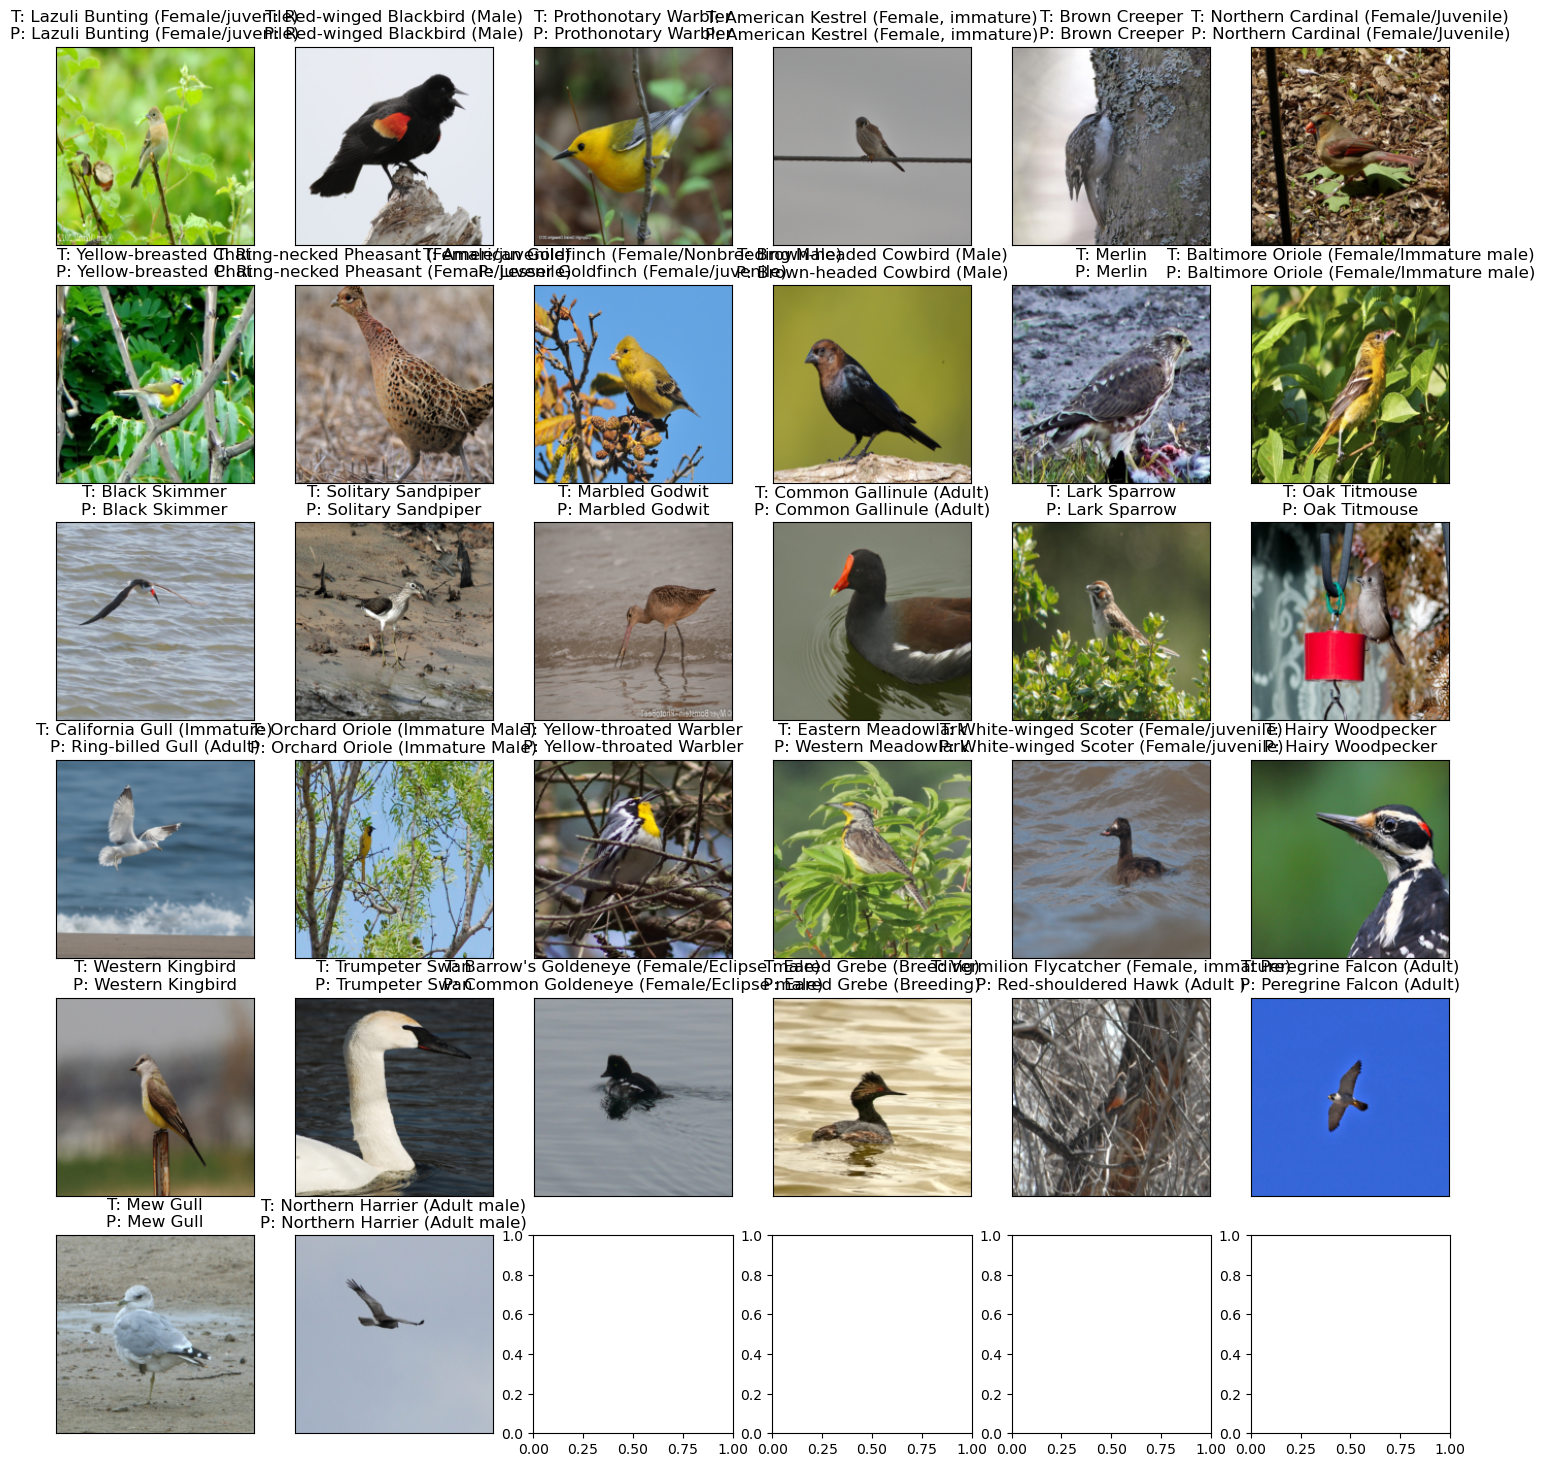

In [46]:
imgs, labels = next(iter(test_dataloader))
#show_img_grid(imgs, titles = map(getter, labels[:9]))
labels = list(map(getter, labels))
infer_show_img_grid(model, imgs, titles=labels)

In [23]:
from datetime import datetime

def save_model(model, path='/content/drive/MyDrive/model.w'):
    # Save model to drive
    torch.save(model.state_dict(), path)

    print('Model saved at: ', datetime.now())

In [25]:
#save_model(model, path='cascade_head_7152acc.w')

In [ ]:
model_2 = create_cascade_model().to(device)
model_2.load_state_dict(torch.load('weight_names'))